# NLP Capstone Project - Rotten Tomatoes Reviews Analysis
## Developing Machine Learning Models using Tf-Idf feature representation

![](https://cdn.steemitimages.com/DQmQZCf7ME7Haj3X3MzXtG8R8JtGmTpuh5NXDSd3wKueva7/rottentomatoes.png)

![ML](https://juststickers.in/wp-content/uploads/2017/04/machine-learning.png)


Moving one from EDA to applying Machine Leaning models with the movie review sentiment analysis dataset. Inparticular the ML models will be developed in conjunction with TF - IDF as feature representation. 

At first, There must be mention that after EDA an odd conclusion was made. The dataset of this competition turned to have some unique features. we have only phrases as data. And a phrase can contain a single word. And one punctuation mark can cause phrase to receive a different sentiment. Also assigned sentiments can be strange. This means several things:

- using stopwords can be a bad idea, especially when phrases contain one single stopword;
- puntuation could be important, so it should be used;
- ngrams are necessary to get the most info from data;
- using features like word count or sentence length won't be useful;

** This thought will be enhanced later with my anomaly detection insights **



## Libraries
Loading most important libraries for the rest of the Machine Learning Analysis.

In [1]:
import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import nltk

### load the dataset

In [2]:
df = pd.read_csv("../input/train.tsv", sep="\t")

In [3]:
df_test = pd.read_csv("../input/test.tsv", sep="\t")

### Preview

In [4]:
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [5]:
df_test.head(10)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


### Tokenizing - Slicing down the sentences into words
Providing some helpers -  functions for future aid.

In [6]:
def tokenize_the_text(phrases):
    
    from nltk.tokenize import word_tokenize
    from nltk.text import Text
    
    tokens = [word for word in phrases]
    tokens = [word.lower() for word in tokens]
    tokens = [word_tokenize(word) for word in tokens]
    
    return tokens

crude_tokens = tokenize_the_text(df.Phrase)
print(crude_tokens[0:10])

[['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.'], ['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['a', 'series'], ['a'], ['series'], ['of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['of'], ['escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['escapades'], ['demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']]


### Creating the main Vocabulary

In [7]:
def create_a_vocab(tokens):
    
    vocab = set()

    for setence in tokens:
        for word in setence:
            vocab.add(word)

    vocab = list(vocab)

    return vocab
    
vocab = create_a_vocab(crude_tokens)

print(len(vocab))

16540


Here are couple of instances where punctuations appeared to be predictive. So if we "cleanedup" the data in the name of data preparation some predictiveness will be lost.

In [8]:
example = df[(df['PhraseId'] >= 0) & (df['PhraseId'] <= 2)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .  - Sentiment: 1

A series of escapades demonstrating the adage that what is good for the goose  - Sentiment: 2


In [9]:
example = df[(df['PhraseId'] >= 517) & (df['PhraseId'] <= 518)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

As inept as big-screen remakes of The Avengers and The Wild Wild West .  - Sentiment: 1

As inept as big-screen remakes of The Avengers and The Wild Wild West  - Sentiment: 2


Below another example that the appearance punctuation symbol "," is important

In [10]:
example = df[(df['PhraseId'] >= 68) & (df['PhraseId'] <= 69)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

quiet , introspective and entertaining  - Sentiment: 3

quiet  - Sentiment: 2


Below another example that the appearance punctuation symbol "!" is important

In [11]:
example = df[(df['PhraseId'] >= 10737) & (df['PhraseId'] <= 10738)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

Just bring on the Battle Bots , please !  - Sentiment: 3

bring on the Battle Bots , please !  - Sentiment: 2


Another strange thing that I discovered is that there are phrases with a single word only and if they disappear at the following phrases the sentiment changes.

In [12]:
example = df[(df['PhraseId'] >= 22) & (df['PhraseId'] <= 24)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

print()

print(example["Phrase"].values[2], " - Sentiment:", example["Sentiment"].values[2])

good for the goose  - Sentiment: 3

good  - Sentiment: 3

for the goose  - Sentiment: 2


In [13]:
example = df[(df['PhraseId'] >= 46) & (df['PhraseId'] <= 47)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

amuses but none of which amounts to much of a story  - Sentiment: 2

amuses  - Sentiment: 3


As you can see sentence id denotes a single review with the phrase column having the entire review text as an input instance followed by random suffixes of the same sentence to form multiple phrases with subsequent phrase ids. This repeats for every single new sentence id (or new review per se). The sentiment is coded with 5 values 0= Very negative to 4=Very positive and everything else in between.

A quick glance will show you that the data is a little weird for a sentiment corpus:

- Phrases of sentences are** chopped up compeltely randomly**. So logic like sentence tokenization based on periods or punctuations or something of that sort doesn't apply
- Certain phrases are **with one single word!**.
- For some phrases inclusion of a punctuation like a comma or a full stop changes the sentiment from say 2 to 3 i.e neutral to positive.
- Some phrases **starts** with a punctuation like a **backquote**.
- Some phrases **end** with a **punctuation**
- There are some ** weird ** words such as ** -RRB-, -LRB- POST tag like a -LRB- **

All these weird aspects of this dataset, can be helpful and may be predictive. Afterall, we are looking for patterns in data. Therefore, it would be easier for us to engineer features, I mean apart from the text features that can be extracted from the corpus.

So, after all this train of thought, let us move on to Machine Learning and Predictive Models.

_________________________

## From Text Data to Feature Extration Representation with TF - IDF using TfidfVectorizer

![TF-IDF](https://i.ytimg.com/vi/bPYJi1E9xeM/maxresdefault.jpg)

TF - IDF is an information retrieval technique that weighs a term’s frequency (TF) and its inverse document frequency (IDF). Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF * IDF weight of that term. The higher the TF * IDF score (weight), the rarer the term and vice versa. The TF * IDF algorithm is used to weigh a keyword in any content and assign the importance to that keyword based on the number of times it appears in the document. More importantly, it checks how relevant the keyword is throughout the web, which is referred to as corpus [source](https://www.elephate.com/blog/what-is-tf-idf/).

### Creating the TF - IDF vectorizer

In [14]:
## TF-IDF and uncleaned dataset

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=tokenizer.tokenize)
full_text = list(df['Phrase'].values) + list(df_test['Phrase'].values)
#full_text

vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(df['Phrase'])
test_vectorized = vectorizer.transform(df_test['Phrase'])

### Shape of TF - IDF vectorizer
we can see that due to the fact the ngram_range is from 1 to 3 the columns of the TF - IDF matrix vectorizer is extremely huge. This may lead us to slow down the Machine Learning models to fit the data.

In [15]:
np.shape(train_vectorized)

(156060, 301627)

# Machine Learning Techiniques for Multiclass Sentiment Analysis

## Evaluating ML Techniques

The Machine Learning models that will be deployed is the following:
 - **Regression Models**: 
     - LogisticRegression
 - **CART Models**: 
     - DecisionTreeClassifier
     - ExtraTreeClassifier
 - **Bagging Trees**: 
     - ExtraTreesClassifier
     - RandomForestClassifier 
 - **SVM Models**: 
     - LinearSVC 
 - **Naive Bayes Models**: 
     - BernoulliNB
     - MultinomialNB
 - **Boosting Trees**: 
     - AdaboostClassifier
     - Extreme Gradient Boosting XGBoost 
 - **Lazy Classifiers**: 
     - KNeighborsClassifier
 
 Since the competion evaluates the models based on accuracy then the models will be evaluated based on accuracy and because the dataset is unbalanced (based on its EDA) us a secondary statistical evaluation metric I will use the F1 score.
 
 The train set will be split in train and validation sets with ratio 80:20.
 
 Finally as a benchmark model, due to the fact that XGBoost is a state of the art model that is widely used in Machine Learning [source](https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html), it will be used as benchmark and the rest of the Machine Learning models will be compared to its performance

In [16]:
X = train_vectorized
y = df.Sentiment.values


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import time

# create a stratified split of the data and a 80/20 split.
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)


In [35]:
ml_default_performance_metrics_df = pd.DataFrame(columns=['accuracy','F1-score','training-time'], index=['LogisticRegression', 'DecisionTreeClassifier', 'ExtraTreeClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'LinearSVC', 'BernoulliNB', 'MultinomialNB', 'AdaboostClassifier', 'XGB', 'KNeighborsClassifier'])


### Multinomial Logistic Regression

              precision    recall  f1-score   support

           0       0.62      0.16      0.26      1414
           1       0.56      0.33      0.42      5455
           2       0.65      0.91      0.76     15917
           3       0.60      0.43      0.50      6585
           4       0.68      0.21      0.32      1841

   micro avg       0.63      0.63      0.63     31212
   macro avg       0.62      0.41      0.45     31212
weighted avg       0.62      0.63      0.60     31212


accuracy_score 0.631840317826477

Weighted Averaged validation metrics
precision_score 0.6232831390820265
recall_score 0.631840317826477
f1_score 0.5951997402747816


elapsed time in seconds:  22.946250677108765



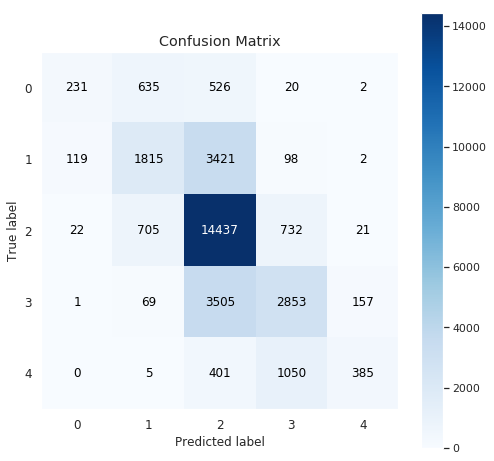

In [36]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()

clf_logistic_regression = LogisticRegression(multi_class='ovr', solver='sag', random_state=42)
clf_logistic_regression.fit(xtrain, ytrain)
predictions = clf_logistic_regression.predict(xvalid)

print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)


ml_default_performance_metrics_df.loc['LogisticRegression']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['LogisticRegression']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['LogisticRegression']['F1-score'] = f1_score(yvalid, predictions, average='micro')


print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

 Logistic Regression , the most prevalent algorithm for solving industry scale problems, although its losing ground to other techniques with progress in efficiency and implementation ease of other complex algorithms.

A very convenient and useful side effect of a logistic regression solution is that it doesn’t give you discrete output or outright classes as output. Instead you get probabilities associated with each observation. You can apply many standard and custom performance metrics on this probability score to get a cutoff and in turn classify output in a way which best fits your business problem. Also, logistic regression is pretty efficient in terms of time and memory requirement.

In addition to above , logistic regression algorithm is robust to small noise in the data and is not particularly affected by mild cases of multi-collinearity. Severe cases of multi-collinearity can be handled by implementing logistic regression with L2 regularization, although if a parsimonious model is needed , L2 regularization is not the best choice because it keeps all the features in the model.

Where logistic regression starts to falter is, when you have a large number of features and good chunk of missing data. Too many categorical variables are also a problem for logistic regression. Another criticism of logistic regression can be that it uses the entire data for coming up with its scores. Although this is not a problem as such, but it can be argued that “obvious” cases which lie at the extreme end of scores should not really be a concern when you are trying to come up with a separation curve. It should ideally be dependent on those boundary cases, some might argue. Also if some of the features are non-linear, you’ll have to rely on transformations, which become a hassle as size of your feature space increases. We have picked few prominent pros and cons from our discussion to summaries things for logistic regression.

Logistic Regression Pros:
- Convenient probability scores for observations
- Efficient implementations available across tools
- Multi-collinearity is not really an issue and can be countered with L2 regularization to an extent
- Wide spread industry comfort for logistic regression solutions
Logistic Regression Cons:
- Doesn’t perform well when feature space is too large
- Doesn’t handle large number of categorical features/variables well
- Relies on transformations for non-linear features
- Relies on entire data

![logistic-regression](https://www.edvancer.in/wp-content/uploads/2015/10/f5bd5f87059fce20564f6e5eb562022e.png)

[source](https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/)

Multinomial Logistic Regression presents a good accuracy 0.63 or 63%. However since the dataset is unbalanced we have to look at the  F1-score and to be more specific the weighted F1-score, We choose the weighted and not the macro or micro because Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall [souce](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). So the weighted F1 score is 0.59. Furthermore the model's training is extremely fast, it takes only 19 seconds! It has a good precision score in phrases for Sentiment 0 to 4.

### DecisionTreeClassifier


Evaluation of DecisionTreeClassifier, with train-test split:
              precision    recall  f1-score   support

           0       0.31      0.24      0.27      1414
           1       0.41      0.33      0.37      5455
           2       0.65      0.77      0.71     15917
           3       0.42      0.36      0.39      6585
           4       0.34      0.25      0.29      1841

   micro avg       0.55      0.55      0.55     31212
   macro avg       0.43      0.39      0.40     31212
weighted avg       0.53      0.55      0.54     31212


accuracy_score 0.5517749583493529

Weighted Averaged validation metrics
precision_score 0.528135877674154
recall_score 0.5517749583493529
f1_score 0.5358109197623023


elapsed time in seconds:  701.0876662731171



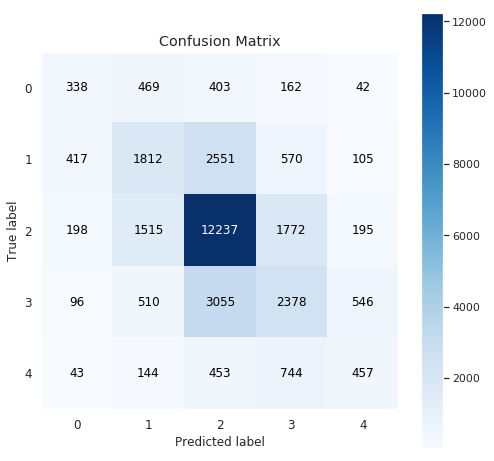

In [37]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
    
print()
print("Evaluation of DecisionTreeClassifier, with train-test split:")

clf_DecisionTreeClassifier = DecisionTreeClassifier(random_state=42)
clf_DecisionTreeClassifier.fit(xtrain, ytrain)
predictions = clf_DecisionTreeClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)


ml_default_performance_metrics_df.loc['DecisionTreeClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['DecisionTreeClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['DecisionTreeClassifier']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

Decision trees cut feature space in rectangles which can adjust themselves to any monotonic transformation. Since decision trees are designed to work with discrete intervals or classes of predictors, any number of categorical variables are not really an issue with decision trees. Models obtained from decision tree is fairly intuitive and easy to explain to business. Probability scores are not a direct result but you can use class probabilities assigned to terminal nodes instead. This brings us to the biggest problem associated with Decision Trees, that is, they are highly biased class of models.

Decision Trees Pros:
- Intuitive Decision Rules
- Can handle non-linear features
- Take into account variable interactions

Decision Trees Cons:
- Highly biased to training set
- No ranking score as direct result

[source](https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/)

![](https://www.edvancer.in/wp-content/uploads/2015/10/9a299e65388a9609d3d567ee3cf7a6c5.png)

Here with this dataset DecisionTree classifier does not perform very well, its accuracy is only 0.55 and F1-score is 0.53. Based on the classification report the classifier performs well in Neutral class only, it has 0.65 precision on the neutral class. However the classifier missclassifies as Neutral Sentiment most of the other phrases. Hence the F1-score is 0.53.

### ExtraTreeClassifier


Evaluation of ExtraTreeClassifier with train-test split:
              precision    recall  f1-score   support

           0       0.36      0.33      0.34      1414
           1       0.48      0.41      0.44      5455
           2       0.68      0.76      0.72     15917
           3       0.48      0.43      0.45      6585
           4       0.42      0.36      0.39      1841

   micro avg       0.59      0.59      0.59     31212
   macro avg       0.48      0.46      0.47     31212
weighted avg       0.57      0.59      0.58     31212


accuracy_score 0.5872741253364091

Weighted Averaged validation metrics
precision_score 0.5736267233189807
recall_score 0.5872741253364091
f1_score 0.5781242535211205


elapsed time in seconds:  134.63076758384705



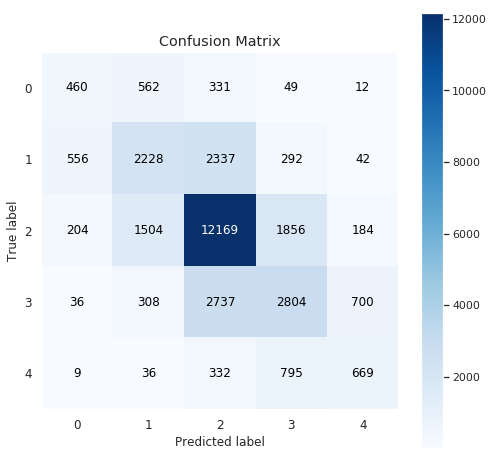

In [38]:
from sklearn.tree import ExtraTreeClassifier

start_time = time.time()
    
print()
print("Evaluation of ExtraTreeClassifier with train-test split:")

clf_ExtraTreeClassifier = ExtraTreeClassifier(random_state=42)
clf_ExtraTreeClassifier.fit(xtrain, ytrain)
predictions = clf_ExtraTreeClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

ml_default_performance_metrics_df.loc['ExtraTreeClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['ExtraTreeClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['ExtraTreeClassifier']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen. When max_features is set 1, this amounts to building a totally random decision tree [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeRegressor.html).

ExtraTreeClassifier does not perform very well, both accuracy and F1-score are below 0.6 or 60%, 0.58 and 0.57 respectively.

### ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

start_time = time.time()
    
print()
print("Evaluation of ExtraTreesClassifier with train-test split:")

clf_ExtraTreesClassifier = ExtraTreesClassifier(n_estimators=10, random_state=42)
clf_ExtraTreesClassifier.fit(xtrain, ytrain)
predictions = clf_ExtraTreesClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['ExtraTreesClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['ExtraTreesClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['ExtraTreesClassifier']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()


Evaluation of ExtraTreesClassifier with train-test split:


This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting [source](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html).

Here we can observe that ExtraTreesClassifier perform quite well, both accuracy and F1-score are above 0.6 or 60%. Especially the classifier has 70% accuracy in neutral phrases.

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
    
print()
print("Evaluation of RandomForestClassifier with train-test split:")

clf_RandomForestClassifier = RandomForestClassifier(n_estimators = 10, random_state=42)
clf_RandomForestClassifier.fit(xtrain, ytrain)
predictions = clf_RandomForestClassifier.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['RandomForestClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['RandomForestClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['RandomForestClassifier']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

Random forest is just an improvement over the top of the decision tree algorithm. The core idea behind Random Forest is to generate multiple small decision trees from random subsets of the data (hence the name “Random Forest”). Each of the decision tree gives a biased classifier (as it only considers a subset of the data). They each capture different trends in the data. This ensemble of trees is like a team of experts each with a little knowledge over the overall subject but thourough in their area of expertise. Now, in case of classification the majority vote is considered to classify a class. In analogy with experts, it is like asking the same multiple choice question to each expert and taking the answer as the one that most no. of experts vote as correct. In case of Regression, we can use the avg. of all trees as our prediction.In addition to this, we can also weight some more decisive trees high relative to others by testing on the validation data.

[source](https://dimensionless.in/introduction-to-random-forest/)

![](https://dimensionless.in/wp-content/uploads/RandomForest_blog_files/figure-html/voting.png)

RandomForest Classifier shows some promising results. Its accuracy and F1-score is 0.62 and 0.60 respectively. However, still the classifier shows great missclassification from phrases with Sentiment 0, 1, 3, 4 to Sentiment 2 based on the high recall to Sentiment 2.

### LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

start_time = time.time()
    
print()
print("Evaluation of LinearSVC, multi_class='ovr', with train-test split:")

clf_LinearSVC = LinearSVC(multi_class='ovr', random_state=42)
clf_LinearSVC.fit(xtrain, ytrain)
predictions = clf_LinearSVC.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['LinearSVC-ovr']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['LinearSVC-ovr']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['LinearSVC-ovr']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

A Support Vector Machine (SVM) is a supervised machine learning algorithm that can be employed for both classification and regression purposes. SVMs are more commonly used in classification problems and as such, this is what we will focus on in this post.
SVMs are based on the idea of finding a hyperplane that best divides a dataset into two classes, as shown in the image below.

![](https://66.media.tumblr.com/ff709fe1c77091952fb3e3e6af91e302/tumblr_inline_o9aa8dYRkB1u37g00_540.png)

Support vectors are the data points nearest to the hyperplane, the points of a data set that, if removed, would alter the position of the dividing hyperplane. Because of this, they can be considered the critical elements of a data set.

As a simple example, for a classification task with only two features (like the image above), you can think of a hyperplane as a line that linearly separates and classifies a set of data.Intuitively, the further from the hyperplane our data points lie, the more confident we are that they have been correctly classified. We therefore want our data points to be as far away from the hyperplane as possible, while still being on the correct side of it. So when new testing data is added, whatever side of the hyperplane it lands will decide the class that we assign to it.

Pros:
- Accuracy
- Works well on smaller cleaner datasets
- It can be more efficient because it uses a subset of training points

Cons:
- Isn’t suited to larger datasets as the training time with SVMs can be high
- Less effective on noisier datasets with overlapping classes

[source](https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html)

LinearSVC classifier exhibits great accuracy so far (0.65) and F1-score 0.64. Nevertheless these encouraging results. The recall in class / Sentiment 2 is high and close to 0.82.


### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

start_time = time.time()
    
print()
print("Evaluation of BernoulliNB with train-test split:")

clf_BernoulliNB = BernoulliNB()
clf_BernoulliNB.fit(xtrain, ytrain)
predictions = clf_BernoulliNB.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['BernoulliNB']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['BernoulliNB']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['BernoulliNB']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()
    
print()
print("Evaluation of MultinomialNB with train-test split:")

clf_MultinomialNB = MultinomialNB()
clf_MultinomialNB.fit(xtrain, ytrain)
predictions = clf_MultinomialNB.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['MultinomialNB']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['MultinomialNB']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['MultinomialNB']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

 ### GaussianNB
 
 I can not use GaussianNNB because the TF-IDF train vector is sparse and it can not work with sparse matrices.

In machine learning, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features [source](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work [source](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features [source](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html).

Both BernouliNB and MultivariateNB classifiers presents not so good accuracy close to 0.6 and F1-score is close to 0.56 and 0.54 respectively. Both have high recall on class 2 which means that they missclassfy lots of the validation data from othejr classes as class 2.

### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

start_time = time.time()
    
print()
print("Evaluation of Adaboost with train-test split:")

clf_adaboost = AdaBoostClassifier(random_state=42)
clf_adaboost.fit(xtrain, ytrain)
predictions = clf_adaboost.predict(xvalid)
print(classification_report(yvalid, predictions))

print()
print("accuracy score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['AdaboostClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['AdaboostClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['AdaboostClassifier']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)


### storing performance results:


print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

The Adaptive Boosting technique works on improving the areas where the base learner fails. The base learner is a machine learning algorithm which is a weak learner and upon which the boosting method is applied to turn it into a strong learner. Any machine learning algorithm that accept weights on training data can be used as a base learner. In the example taken below, Decision stumps are used as the base learner. The training data are randomly sampled in sample points and from this data they areapplied decision stump algorithm to classify the points. After classifying the sampled points we fit the decision tree stump to the complete training data. This process iteratively happens until the complete training data fits without any error or until a specified maximum number of estimators [source](https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c).

However Adaboost classifier has disappointing results, both accuracy and F1-score are 0.54 and 0.45 respectively.

### Xgboost

In [ ]:
import xgboost as xgb

start_time = time.time()

clf_xgb = xgb.XGBClassifier(objective = 'multi:softmax', seed=42)
clf_xgb.fit(xtrain, ytrain)
predictions = clf_xgb.predict(xvalid)

print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['XGB']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['XGB']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['XGB']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

XGBoost is one of the state of the art algorithms. XGBoost is a part of an ensemble of classifiers which are used to win data science competitions. XGBoost is similar to gradient boosting algorithm but it has a few tricks up its sleeve which makes it stand out from the rest.

Features of XGBoost are:
- Clever Penalisation of Trees
- A Proportional shrinking of leaf nodes
- Newton Boosting
- Extra Randomisation Parameter

Unfortunately, XGBoost classifier performs poorly in this dataset. Only 0.54 accuracy and 0.45 F1-score with default paremeters.

### KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

clf_knn = KNeighborsClassifier()
clf_knn.fit(xtrain, ytrain)
predictions = clf_knn.predict(xvalid)

print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, predictions, average='weighted'))
print("recall_score", recall_score(yvalid, predictions, average='weighted'))
print("f1_score", f1_score(yvalid, predictions, average='weighted'))


ml_default_performance_metrics_df.loc['KNeighborsClassifier']['training-time'] = time.time() - start_time
ml_default_performance_metrics_df.loc['KNeighborsClassifier']['accuracy'] = accuracy_score(yvalid, predictions)
ml_default_performance_metrics_df.loc['KNeighborsClassifier']['F1-score'] = f1_score(yvalid, predictions, average='weighted')

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, predictions)

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

k-nearest neighbors (or k-NN for short) is a simple machine learning algorithm that categorizes an input by using its k nearest neighbors. K-NN is non-parametric, which means that it does not make any assumptions about the probability distribution of the input. This is useful for applications with input properties that are unknown and therefore makes k-NN more robust than algorithms that are parametric. The contrast is that parametric machine learning algorithms tend to produce fewer errors than non-parametric ones, since taking input probabilities into account can influence decision making.

Furthermore, k-NN is a type of lazy learning, which is a learning method that generalizes data in the testing phase, rather than during the training phase. This is contrasted with eager learning, which generalizes data in the training phase rather than the testing phase. A benefit of lazy learning is that it can quickly adapt to changes, since it is not expecting a certain generalized dataset. However, a major downside is that a huge amount of computation occurs during testing (actual use) rather than pre-computation during training [source](https://brilliant.org/wiki/k-nearest-neighbors/).

Here KNN classifier performs neither well or poorly. Its accuracy and F1-score are both 0.59 however presents in all classes high recall score which means KNN missclassfies most of the cases.

### Performance results sorted by accuracy score

In [34]:
ml_default_performance_metrics_df.sort_values(by="accuracy", ascending=False)

,accuracy,F1-score,training-time
LinearSVC-ovr,0.654268,0.645799,11.8419
LogisticRegression,0.63184,0.63184,19.1938
ExtraTreesClassifier,0.627867,0.615518,1360.21
RandomForestClassifier,0.621716,0.60068,671.089
MultinomialNB,0.606465,0.546316,0.201395
BernoulliNB,0.602332,0.568562,0.326039
KNeighborsClassifier,0.595668,0.592985,145.863
ExtraTreeClassifier,0.587274,0.578124,124.298
DecisionTreeClassifier,0.551775,0.535811,633.558
AdaboostClassifier,0.542612,0.456461,180.597


### Summarizing ML Classifiers based on their accuracy with TF - IDF as Feature Extraction

In [ ]:
ml_default_performance_metrics_df.sort_values(by="F1-score", ascending=False).accuracy.plot(kind="bar")

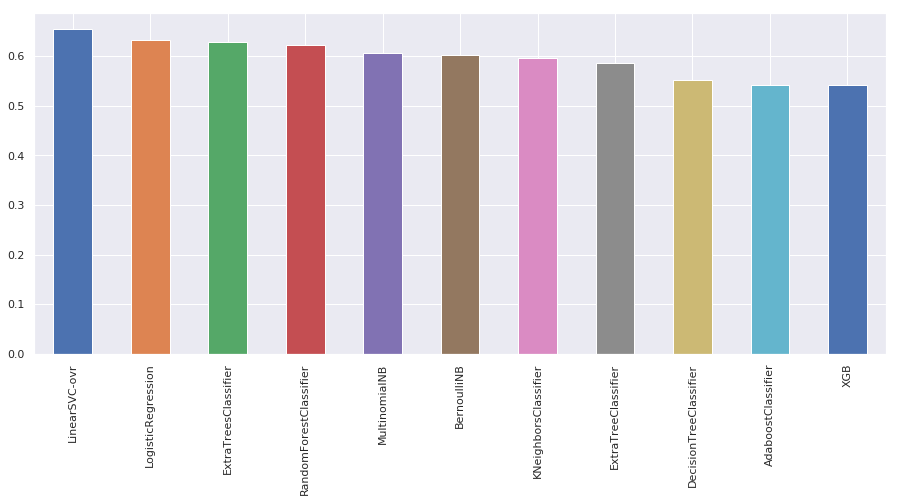

In [31]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
ml_default_performance_metrics_df.sort_values(by="accuracy", ascending=False).accuracy.plot(kind="bar")

### Summarizing ML Classifiers based on their F1-score with TF - IDF as Feature Extraction

In [ ]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
ml_default_performance_metrics_df.sort_values(by="F1-score", ascending=False).accuracy.plot(kind="bar")

### Performance results sorted by training time

In [32]:
ml_default_performance_metrics_df.sort_values(by="training-time", ascending=True)

,accuracy,F1-score,training-time
MultinomialNB,0.606465,0.546316,0.201395
BernoulliNB,0.602332,0.568562,0.326039
LinearSVC-ovr,0.654268,0.645799,11.8419
LogisticRegression,0.63184,0.63184,19.1938
ExtraTreeClassifier,0.587274,0.578124,124.298
KNeighborsClassifier,0.595668,0.592985,145.863
AdaboostClassifier,0.542612,0.456461,180.597
XGB,0.542484,0.449187,428.718
DecisionTreeClassifier,0.551775,0.535811,633.558
RandomForestClassifier,0.621716,0.60068,671.089


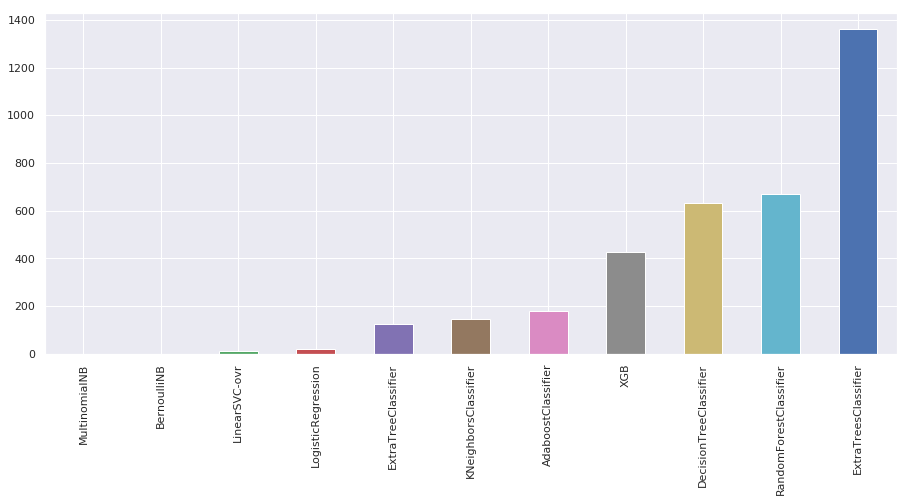

In [33]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
ml_default_performance_metrics_df.sort_values(by="training-time", ascending=True)["training-time"].plot(kind="bar")

## Producing Predictions for the Test Set for the top 5 best performed ML models with default paremeters

In [ ]:
df_test = pd.read_csv("../input/test.tsv", sep="\t")

test_vectorized = vectorizer.transform(df_test['Phrase'])

predictions_default_linear_svc = clf_LinearSVC.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_linear_svc
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_linear_svc.csv',index=False)

predictions_default_logistic_regression = clf_logistic_regression.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_logistic_regression
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_logistic_regression.csv',index=False)

predictions_default_extra_trees = clf_ExtraTreesClassifier.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_extra_trees
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_extra_trees.csv',index=False)

predictions_default_random_forest = clf_RandomForestClassifier.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_random_forest
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_random_forest.csv',index=False)

predictions_default_MultinomialNB = clf_MultinomialNB.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_default_MultinomialNB
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_MultinomialNB.csv',index=False)

## Ensemble Predictions from Test Set from the top 5 best performed ML models with default parameters

In [ ]:
ensemble_all_ml_default_pred_test_df = pd.DataFrame({
    'linear_svc':predictions_default_linear_svc,
    'logistic_regression':predictions_default_logistic_regression,
    'extra_trees':predictions_default_extra_trees,
    'random_forest':predictions_default_random_forest,
    'MultinomialNB':predictions_default_MultinomialNB})


pred_default_test_mode = ensemble_all_ml_default_pred_test_df.agg('mode',axis=1)[0].values
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = pred_default_test_mode
submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_ml_default_ensemble.csv',index=False)

### Tuning the top 5 best performed ML Models

- SVM
- Logistic Regression
- ExtraTrees Tuning
- RandomForest Tuning
- MultinomialNB

In [ ]:
ml_tuning_performance_metrics_df = pd.DataFrame(columns=['accuracy','F1-score','training-time'], index=['LogisticRegression', 'ExtraTreesClassifier', 'RandomForestClassifier', 'LinearSVC-ovr', 'MultinomialNB'])

### LinearSVC (OVR) tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import time

start_time = time.time()
print("Linear SVC grid Search:")

clf_linear_svc_grid = LinearSVC(multi_class='ovr', random_state=42)

X = train_vectorized
y = df.Sentiment.values

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

gsc_linear_svc = GridSearchCV(
    estimator=clf_linear_svc_grid,
    param_grid={
        'C': [10e-1, 10e-2, 1, 10],
        'tol': [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e-0, 10e+1],
    },
    scoring='accuracy',
    cv=2
)

grid_result_linear_svc = gsc_linear_svc.fit(xtrain, ytrain)

print()
print("ExtraTreesClassifier best parameters and score")
print("Best score: %f using %s" % (grid_result_linear_svc.best_score_, grid_result_linear_svc.best_params_))

prediction_tuned_linear_svc = gsc_linear_svc.predict(xvalid)
print("accuracy score after tuning:", accuracy_score(yvalid, prediction_tuned_linear_svc))

ml_tuning_performance_metrics_df.loc['LinearSVC-ovr']['training-time'] = time.time() - start_time
ml_tuning_performance_metrics_df.loc['LinearSVC-ovr']['accuracy'] = accuracy_score(yvalid, prediction_tuned_linear_svc)
ml_tuning_performance_metrics_df.loc['LinearSVC-ovr']['F1-score'] = f1_score(yvalid, prediction_tuned_linear_svc, average='macro')

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

### Logistic Regression Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time

start_time = time.time()
print("LogisticRegression grid Search:")

clf_logistic_regression_grid = LogisticRegression(multi_class = 'ovr', random_state=42)

X = train_vectorized
y = df.Sentiment.values

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

gsc_logistic_regression = GridSearchCV(
    estimator=clf_logistic_regression_grid,
    param_grid={
        'solver': ['newton-cg', 'sag', 'saga'],
        'C': [10e-1, 10e-2, 1, 10],
        'tol': [10e-4, 10e-3, 10e-2, 10e-1, 10e-0],
    },
    scoring='accuracy',
    cv=2
)

grid_result_logistic_regression = gsc_logistic_regression.fit(xtrain, ytrain)

print()
print("LogisticRegression best parameters and score")
print("Best score: %f using %s" % (grid_result_logistic_regression.best_score_, grid_result_logistic_regression.best_params_))

prediction_tuned_logistic_regression = grid_result_logistic_regression.predict(xvalid)
print("accuracy score after tuning:", accuracy_score(yvalid, prediction_tuned_logistic_regression))

ml_tuning_performance_metrics_df.loc['LogisticRegression']['training-time'] = time.time() - start_time
ml_tuning_performance_metrics_df.loc['LogisticRegression']['accuracy'] = accuracy_score(yvalid, prediction_tuned_logistic_regression)
ml_tuning_performance_metrics_df.loc['LogisticRegression']['F1-score'] = f1_score(yvalid, prediction_tuned_logistic_regression, average='macro')

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

### ExtraTrees Tuning

In [ ]:
# I will perform a shallow grid search 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
import time

start_time = time.time()
print("ExtraTreesClassifier grid Search:")

clf_extra_trees_grid = ExtraTreesClassifier(random_state=42)

X = train_vectorized
y = df.Sentiment.values

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

gsc_extra_trees = GridSearchCV(
    estimator=clf_extra_trees_grid,
    param_grid={
        'n_estimators': [2, 4, 6, 8, 10, 12]
    },
    scoring='accuracy',
    cv=2
)

grid_result_extra_trees = gsc_extra_trees.fit(xtrain, ytrain)

print()
print("ExtraTreesClassifier best parameters and score")
print("Best score: %f using %s" % (grid_result_extra_trees.best_score_, grid_result_extra_trees.best_params_))

prediction_tuned_extra_trees = grid_result_extra_trees.predict(xvalid)
print("accuracy score after tuning:", accuracy_score(yvalid, prediction_tuned_extra_trees))

ml_tuning_performance_metrics_df.loc['ExtraTreesClassifier']['training-time'] = time.time() - start_time
ml_tuning_performance_metrics_df.loc['ExtraTreesClassifier']['accuracy'] = accuracy_score(yvalid, prediction_tuned_extra_trees)
ml_tuning_performance_metrics_df.loc['ExtraTreesClassifier']['F1-score'] = f1_score(yvalid, prediction_tuned_extra_trees, average='macro')

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

### RandomForestClassifier Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
print("RandomForestClassifier grid Search:")

clf_random_forest = RandomForestClassifier(random_state=42)

X = train_vectorized
y = df.Sentiment.values

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

gsc_random_forest = GridSearchCV(
    estimator=clf_random_forest,
    param_grid={
        'n_estimators': [2, 4, 6, 8, 10, 12]
    },
    scoring='accuracy',
    cv=2
)

grid_result_random_forest = gsc_random_forest.fit(xtrain, ytrain)

print()
print("RandomForest best parameters and score")
print("Best: %f using %s" % (grid_result_random_forest.best_score_, grid_result_random_forest.best_params_))

prediction_tuned_random_forest = grid_result_random_forest.predict(xvalid)
print("accuracy score after tuning:", accuracy_score(yvalid, prediction_tuned_random_forest))

ml_tuning_performance_metrics_df.loc['RandomForestClassifier']['training-time'] = time.time() - start_time
ml_tuning_performance_metrics_df.loc['RandomForestClassifier']['accuracy'] = accuracy_score(yvalid, prediction_tuned_random_forest)
ml_tuning_performance_metrics_df.loc['RandomForestClassifier']['F1-score'] = f1_score(yvalid, prediction_tuned_random_forest, average='macro')

print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

### MultinomialNB Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import time

start_time = time.time()
print("MultinomialNB grid Search:")

clf_MultinomialNB_grid = BernoulliNB()

X = train_vectorized
y = df.Sentiment.values

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)


gsc_MultinomialNB = GridSearchCV(
    estimator=clf_MultinomialNB_grid,
    param_grid={
        'fit_prior': [True, False]
    },
    scoring='accuracy',
    cv=2
)

grid_result_MultinomialNB = gsc_MultinomialNB.fit(xtrain, ytrain)

print()
print("MultinomialNB best parameters and score")
print("Best: %f using %s" % (grid_result_MultinomialNB.best_score_, grid_result_MultinomialNB.best_params_))

prediction_tuned_MultinomialNB = grid_result_MultinomialNB.predict(xvalid)
print("accuracy score after tuning:", accuracy_score(yvalid, prediction_tuned_MultinomialNB))


ml_tuning_performance_metrics_df.loc['MultinomialNB']['training-time'] = time.time() - start_time
ml_tuning_performance_metrics_df.loc['MultinomialNB']['accuracy'] = accuracy_score(yvalid, prediction_tuned_MultinomialNB)
ml_tuning_performance_metrics_df.loc['MultinomialNB']['F1-score'] = f1_score(yvalid, prediction_tuned_MultinomialNB, average='macro')


print()
print("elapsed time in seconds: ", time.time() - start_time)
print()

In [ ]:
ml_tuning_performance_metrics_df.sort_values(by="accuracy", ascending=False)

## ML Predictions with Test Set

In [ ]:
df_test = pd.read_csv("../input/test.tsv", sep="\t")

test_vectorized = vectorizer.transform(df_test['Phrase'])

predictions_tuned_test_linear_svc = grid_result_linear_svc.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_tuned_test_linear_svc
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_tuned_linear_svc.csv',index=False)

predictions_tuned_test_logistic_regression = grid_result_logistic_regression.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_tuned_test_logistic_regression
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_tuned_logistic_regression.csv',index=False)

predictions_tuned_test_extra_trees = grid_result_extra_trees.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_tuned_test_extra_trees
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_tuned_extra_trees.csv',index=False)

predictions_tuned_test_random_forest = grid_result_random_forest.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_tuned_test_random_forest
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_tuned_random_forest.csv',index=False)

predictions_tuned_test_MultinomialNB = grid_result_MultinomialNB.predict(test_vectorized)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = predictions_tuned_test_MultinomialNB
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_tuned_MultinomialNB.csv',index=False)

### Ensemble Predictions after Tuning from top 5 best performed ML Techniques after tuning

In [ ]:
ensemble_all_ml_tuned_pred_test_df = pd.DataFrame({
    'linear_svc':predictions_tuned_test_linear_svc,
    'logistic_regression':predictions_tuned_test_logistic_regression,
    'extra_trees':predictions_tuned_test_extra_trees,
    'random_forest':predictions_tuned_test_random_forest,
    'MultinomialNB':predictions_tuned_test_MultinomialNB})


pred_tuned_test_mode = ensemble_all_ml_tuned_pred_test_df.agg('mode',axis=1)[0].values
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = pred_tuned_test_mode
submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_ml_tuned_ensemble.csv',index=False)

___________________________________________________________________